### 1) Explore image dataset (faces in wild) and import dependencies

(1896, 8742)
(1896, 3, 62, 47)


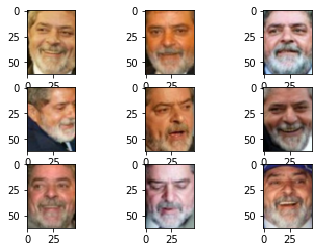

In [4]:

#produce image from vectors
#explore dataset
from sklearn.datasets import fetch_lfw_pairs
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot
from scipy.misc import toimage
from time import time
import logging
import matplotlib.pyplot as plt

from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, Convolution2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
from matplotlib import pyplot as plt

from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D,Convolution2D
from keras.utils import np_utils
import h5py
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
lfw_people = fetch_lfw_people(min_faces_per_person=30,color=True) #resize, slice, color parameter
num_pics, h, w, d = lfw_people.images.shape
X=lfw_people.data  #this is our main training set 
n_features=X.shape[1] #basically number of pixels (h*w)
target_labels=lfw_people.target #labels of classes for each value in x
y=target_labels
target_names=lfw_people.target_names #maps target label to name
num_classes=target_names.shape[0]
#target_names[y[229]] #remember this changes in next step cause we apply random in sklearn dataset fomation

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42) #split into training and testing set
print(X_train.shape)
X_train=X_train.reshape(X_train.shape[0],62,47,3)
X_test=X_test.reshape(X_test.shape[0],62,47,3)
X_train=np.transpose(X_train,(0,3,1,2)) #transposing matrix for reshaping according to th ordering
print(X_train.shape)
train_indices=[np.where(y_train==i)[0] for i in range(num_classes)] #np.where gives all indices for condition as a tuple list

class_no = 23 #this is the person's class no.
for i, image_index in enumerate(train_indices[class_no]):
    if(i<9): #pyplot works for upto 9 I think
        pyplot.subplot(330 + i+1) #330 for subplot
        pyplot.imshow(toimage(X_train[image_index]))

pyplot.show()
#X_train.shape

### 2) Primary model code

In [7]:
# Initialize dataset, number of features, number of classes, target labels and target names
#CONVNET

K.set_image_dim_ordering('th') #most models like vgg work with th ordering

lfw_people = fetch_lfw_people(min_faces_per_person=30,color=True) #resize, slice, color parameter
num_pics, h, w, c = lfw_people.images.shape
X=lfw_people.data  #this is our main training set 
n_features=X.shape[1] #basically number of pixels (h*w)
target_labels=lfw_people.target #labels of classes for each value in x
y=target_labels
target_names=lfw_people.target_names #maps target label to name
num_classes=target_names.shape[0]
#target_names[y[229]] #remember this changes in next step cause we apply random in sklearn dataset fomation
seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state= seed) #split into training and testing set
print(X_train[0].shape)
#X_train=X_train.reshape(X_train.shape[0],3,62,47) #shape dependent on image ordering




#reshape image dimensions
X_train=X_train.reshape(X_train.shape[0],62,47,3) #input dataset
X_test=X_test.reshape(X_test.shape[0],62,47,3)
X_train=np.transpose(X_train,(0,3,1,2))# or 2,1,0 and transpose
X_test=np.transpose(X_test,(0,3,1,2))
#X_train=X_train.reshape(X_train.shape[0],3,62,224) #shape dependent on image ordering
#X_test=X_test.reshape(X_test.shape[0],3,224,224)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0   #WHY DOES THIS HELP
print("Training and testing shape {} and {}".format(X_train.shape,X_test.shape) )  
print("Number of classes/people {}".format(num_classes))
#print

#find indices of classes
train_indices=[np.where(y_train==i)[0] for i in range(num_classes)]
test_indices=[np.where(y_test==i)[0] for i in range(num_classes)]

def create_positive_negative_pairs(dataset,indices):
    # this function can be IMPROVED to generate more EXAMPLES
    min_examples= min([len(indices[i]) for i in range(num_classes)]) -1 #this allows us to assume that index_j would not exceed for a given class 
    pairs=[]  #[[same,same],[same,diff]]
    labels=[] #[[]]
    #we will create pairs by taking i with i+1, then i with i of another class
    #then again i+1 with i+2 
    #IMPROVE to make i with i+1, i+2 i+3 ... n-1 where n is min number of same classes
    ''' 
   for class_i in range(num_classes):
        for index_j in range(min_examples):
            
            index1, index2 = indices[class_i][index_j], indices[class_i][index_j+1]
            pairs+=[[dataset[index1],dataset[index2]]]
            #choose another random class, notice the range choice is 1 till num_classes -1 
            class_not_same= (class_i+random.randrange(1,num_classes))%num_classes
            index1, index2= indices[class_i][index_j], indices[class_not_same][index_j]
            pairs+=[[dataset[index1],dataset[index2]]] 
            labels+=[1,0]
    return np.array(pairs), np.array(labels)
    '''
    for class_i in range(num_classes):
        for index_j in range(min_examples):
            for index_above_j in range(index_j+1,min_examples): 
                index1, index2 = indices[class_i][index_j], indices[class_i][index_above_j]
                pairs+=[[dataset[index1],dataset[index2]]]
                labels+=[1]
            #choose another random class, notice the range choice is 1 till num_classes -1 
            class_not_same= (class_i+random.randrange(1,num_classes))%num_classes
            for index_above_j in range(index_j,min_examples):
                index1, index2= indices[class_i][index_j], indices[class_not_same][index_above_j]
                pairs+=[[dataset[index1],dataset[index2]]] 
                labels+=[0]
    return np.array(pairs), np.array(labels)



train_pairs,train_labels=create_positive_negative_pairs(X_train,train_indices)
test_pairs,test_labels=create_positive_negative_pairs(X_test,test_indices)
                    
print("Shape of pairs: {}".format(train_pairs.shape)) #basically number of pairs * pair (2) * dimension of each image
print(train_pairs[0])
print("Shape of labels: {}".format(train_labels.shape))

#so in our model we will make it to receive two inputs--> pair[0] (of ndim) and pair[1] (of ndim), and one output--> the distance
#input_dim=train_pairs.shape[2]  #supply input dimensions for base network model
input_dim=(3,62,47) #contingent on image ordering (keras backend)




def siemese_base_net(input_tensor_shape,weights_path=None):
    
    #keras image ordering is important the input shape changes with image ordering 3,h,w is for th and h,w,3 is for tf
    ''' #60% 45%
    seq = Sequential()
    seq.add(Conv2D(32, (3, 3), input_shape=(3, 62, 47), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
    seq.add(Dropout(0.2))
    seq.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Flatten())
    seq.add(Dense(256, activation='relu', kernel_constraint=maxnorm(3)))
    seq.add(Dropout(0.3))
    return seq
    '''
    '''Accuracy on training set: 72.38%
Accuracy on testing set: 37.08%'''
    
    seq = Sequential() #some internet model
    seq.add(Conv2D(32, (3, 3), input_shape=(3,62, 47), activation='relu', padding='same'))
    seq.add(Dropout(0.2))
    seq.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    seq.add(Dropout(0.2))
    seq.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    seq.add(Dropout(0.2))
    seq.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Flatten())
    seq.add(Dropout(0.2))
    seq.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    seq.add(Dropout(0.2))
    seq.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    seq.add(Dropout(0.2))
    return seq
    
    '''
    ''''''
    seq = Sequential()   #VGG MODEL
    seq.add(ZeroPadding2D((1,1),input_shape=(3,62,47)))
    #seq.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    seq.add(Convolution2D(64, 3, 3, activation='relu'))
    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(64, 3, 3, activation='relu'))
    seq.add(MaxPooling2D((2,2), strides=(2,2)))

    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(128, 3, 3, activation='relu'))
    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(128, 3, 3, activation='relu'))
    seq.add(MaxPooling2D((2,2), strides=(2,2)))

    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(256, 3, 3, activation='relu'))
    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(256, 3, 3, activation='relu'))
    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(256, 3, 3, activation='relu'))
    seq.add(MaxPooling2D((2,2), strides=(2,2)))

    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(512, 3, 3, activation='relu'))
    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(512, 3, 3, activation='relu'))
    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(512, 3, 3, activation='relu'))
    seq.add(MaxPooling2D((2,2), strides=(2,2)))

    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(512, 3, 3, activation='relu'))
    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(512, 3, 3, activation='relu'))
    seq.add(ZeroPadding2D((1,1)))
    seq.add(Convolution2D(512, 3, 3, activation='relu'))
    seq.add(MaxPooling2D((2,2), strides=(2,2)))

    seq.add(Flatten())
    seq.add(Dense(4096, activation='relu'))
    seq.add(Dropout(0.5))
    seq.add(Dense(4096, activation='relu'))
    seq.add(Dropout(0.5))
    seq.add(Dense(1000, activation='softmax'))
    
    '''
    '''    seq.load_weights('vgg16tf.h5')
    '''
    return seq


siemese_base_network= siemese_base_net(input_dim)
#1st STEP: Make input tensors
input_a=Input(shape=input_dim)  #(input_dim,) vs (input_dim) remember how numpy views work (indexing)
input_b=Input(shape=input_dim)
#2nd STEP: Make model passing in input tensors


def euc_dist(input_tensors): #from keras source code for siemese networks
    x,y = input_tensors
    #use tensorflow calculation
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

#DOUBT 2 what is the parameter shapes for below function
def euc_oshape(shapes): 
    shape1,shape2=shapes
    
    return (shape1[0],1)
    

# adapted from keras author code
    
processed_a=siemese_base_network(input_a) #output from our base network for pair[0]
processed_b=siemese_base_network(input_b) #output from our base network for pair[1]
#3rd STEP: Make output model, in this case a lambda to use tensorflow dependencies as K
distance= Lambda(euc_dist, output_shape=euc_oshape)([processed_a,processed_b])
#DOUBT 1 is there a difference between models.concatenate([a,b]) and just [a,b]; ans: [a,b]  doesn't combine them into one tensor, it treats them as two seperate input tensors

#4th step create base model so inputs are [a,b] and output is our distance model
#Remember distance model's input is [processed_a and b] which is the base network model output 
model=Model([input_a,input_b],distance)

#optimizer 
rms= RMSprop()
epochs = 300

def contrastive_loss(y_true, y_pred): #loss function based on research paper 
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


model.compile(loss=contrastive_loss,optimizer=rms,metrics=['accuracy'])
#train_pairs[:,0] or [:,0,:] means for all rows, take first column, and entire embedding 
#and the batch size is 128, so at one epoch 128 batches of the total training size (in this case training pairs) are prepared to train the model, and the output is a shape of number of (training size,1)
model.fit([train_pairs[:, 0],train_pairs[:, 1]],train_labels,
         batch_size=128,
         epochs=epochs,
         validation_data=([test_pairs[:,0],test_pairs[:,1]],test_labels)) #this is the training where epochs occur

model.summary()

#now to find the model accuracy and perform predictions

#DOUBT 3
def compute_accuracy(predictions,labels):
    #predictions.ravel flattens array then < 0.5 are all indices where prediction <0.5 
    return labels[predictions.ravel() < 0.5].mean() #how??

train_pred=model.predict([train_pairs[:, 0],train_pairs[:,1]]) #we'll test how our model does on its training set
#pred is basically an array of predictions (0 or 1 in this case)
train_acc=compute_accuracy(train_pred,train_labels)

test_pred=model.predict([test_pairs[:,0],test_pairs[:,1]])
test_acc=compute_accuracy(test_pred,test_labels)



print("Accuracy on training set: %0.2f%%" %(100*train_acc))

print("Accuracy on testing set: %0.2f%%" %(100*test_acc))


##Prediction code:
#Take 1 class and go through every other class get prediction and output max image
input_image_dim=X_test[0]
true_output=y_test[0]
test_classes=[np.where]
output_pred=model.predict([input_image,])


##QUESTIONS
''' 
1) Why did normalization make the model perform so much better?
2) How to remove background green to focus on face, or find a face IMAGE preprocessing for footy
3) How to make predictions between pairs faster? hashing
Performance vs http://efavdb.com/machine-learning-for-facial-recognition-3/
mosse recognition
'''

(8742,)
Training and testing shape (1896, 3, 62, 47) and (474, 3, 62, 47)
Number of classes/people 34
Shape of pairs: (14994, 2, 3, 62, 47)
[[[[ 0.07450981  0.07058824  0.07450981 ...,  0.1254902   0.12156863
     0.13725491]
   [ 0.05490196  0.06666667  0.09803922 ...,  0.1254902   0.11372549
     0.12941177]
   [ 0.08235294  0.10588235  0.13333334 ...,  0.14117648  0.13333334
     0.12156863]
   ..., 
   [ 0.79215688  0.85882354  0.87843138 ...,  0.40392157  0.44705883
     0.52156866]
   [ 0.48627451  0.76078433  0.86274511 ...,  0.4627451   0.57647061
     0.68627453]
   [ 0.15686275  0.48627451  0.78823531 ...,  0.5529412   0.65490198
     0.7019608 ]]

  [[ 0.11372549  0.10588235  0.10980392 ...,  0.14901961  0.12941177
     0.12941177]
   [ 0.08627451  0.10588235  0.14117648 ...,  0.15686275  0.13725491
     0.13333334]
   [ 0.10980392  0.14117648  0.17254902 ...,  0.16470589  0.16862746
     0.14901961]
   ..., 
   [ 0.85882354  0.9254902   0.94901961 ...,  0.23529412  0.262745

14994/14994 [==============================] - 36s - loss: 0.1249 - acc: 0.1138 - val_loss: 0.2344 - val_acc: 0.3693
Epoch 39/300
14994/14994 [==============================] - 37s - loss: 0.1227 - acc: 0.1113 - val_loss: 0.2465 - val_acc: 0.3889
Epoch 40/300
14994/14994 [==============================] - 36s - loss: 0.1202 - acc: 0.1062 - val_loss: 0.1991 - val_acc: 0.2778
Epoch 41/300
14994/14994 [==============================] - 37s - loss: 0.1181 - acc: 0.1040 - val_loss: 0.2482 - val_acc: 0.4183
Epoch 42/300
14994/14994 [==============================] - 36s - loss: 0.1178 - acc: 0.1015 - val_loss: 0.2053 - val_acc: 0.3007
Epoch 43/300
14994/14994 [==============================] - 37s - loss: 0.1154 - acc: 0.0950 - val_loss: 0.2215 - val_acc: 0.3497
Epoch 44/300
14994/14994 [==============================] - 36s - loss: 0.1142 - acc: 0.0902 - val_loss: 0.2102 - val_acc: 0.3007
Epoch 45/300
14994/14994 [==============================] - 37s - loss: 0.1136 - acc: 0.0915 - val_loss

14994/14994 [==============================] - 37s - loss: 0.0927 - acc: 0.0484 - val_loss: 0.2028 - val_acc: 0.2876
Epoch 102/300
14994/14994 [==============================] - 37s - loss: 0.0926 - acc: 0.0449 - val_loss: 0.2142 - val_acc: 0.3301
Epoch 103/300
14994/14994 [==============================] - 37s - loss: 0.0930 - acc: 0.0474 - val_loss: 0.2792 - val_acc: 0.5033
Epoch 104/300
14994/14994 [==============================] - 37s - loss: 0.0933 - acc: 0.0477 - val_loss: 0.2827 - val_acc: 0.5000
Epoch 105/300
14994/14994 [==============================] - 37s - loss: 0.0928 - acc: 0.0458 - val_loss: 0.1830 - val_acc: 0.2451
Epoch 106/300
14994/14994 [==============================] - 37s - loss: 0.0923 - acc: 0.0435 - val_loss: 0.1896 - val_acc: 0.2484
Epoch 107/300
14994/14994 [==============================] - 37s - loss: 0.0928 - acc: 0.0462 - val_loss: 0.2347 - val_acc: 0.3954
Epoch 108/300
14994/14994 [==============================] - 37s - loss: 0.0926 - acc: 0.0454 - v

14994/14994 [==============================] - 37s - loss: 0.0905 - acc: 0.0469 - val_loss: 0.1753 - val_acc: 0.2124
Epoch 164/300
14994/14994 [==============================] - 37s - loss: 0.0905 - acc: 0.0475 - val_loss: 0.1905 - val_acc: 0.2451
Epoch 165/300
14994/14994 [==============================] - 37s - loss: 0.0909 - acc: 0.0460 - val_loss: 0.1998 - val_acc: 0.2908
Epoch 166/300
14994/14994 [==============================] - 37s - loss: 0.0908 - acc: 0.0458 - val_loss: 0.3453 - val_acc: 0.5850
Epoch 167/300
14994/14994 [==============================] - 37s - loss: 0.0907 - acc: 0.0488 - val_loss: 0.1856 - val_acc: 0.2484
Epoch 168/300
14994/14994 [==============================] - 37s - loss: 0.0911 - acc: 0.0480 - val_loss: 0.2142 - val_acc: 0.3235
Epoch 169/300
14994/14994 [==============================] - 37s - loss: 0.0907 - acc: 0.0474 - val_loss: 0.2093 - val_acc: 0.3562
Epoch 170/300
14994/14994 [==============================] - 37s - loss: 0.0905 - acc: 0.0466 - v

14994/14994 [==============================] - 37s - loss: 0.0907 - acc: 0.0484 - val_loss: 0.2320 - val_acc: 0.3627
Epoch 226/300
14994/14994 [==============================] - 37s - loss: 0.0902 - acc: 0.0466 - val_loss: 0.2214 - val_acc: 0.3203
Epoch 227/300
14994/14994 [==============================] - 37s - loss: 0.0909 - acc: 0.0478 - val_loss: 0.2245 - val_acc: 0.3693
Epoch 228/300
14994/14994 [==============================] - 37s - loss: 0.0899 - acc: 0.0475 - val_loss: 0.2457 - val_acc: 0.3791
Epoch 229/300
14994/14994 [==============================] - 37s - loss: 0.0903 - acc: 0.0504 - val_loss: 0.1944 - val_acc: 0.2614
Epoch 230/300
14994/14994 [==============================] - 37s - loss: 0.0896 - acc: 0.0485 - val_loss: 0.1951 - val_acc: 0.2876
Epoch 231/300
14994/14994 [==============================] - 37s - loss: 0.0897 - acc: 0.0471 - val_loss: 0.2020 - val_acc: 0.3039
Epoch 232/300
14994/14994 [==============================] - 37s - loss: 0.0890 - acc: 0.0463 - v

14994/14994 [==============================] - 37s - loss: 0.0896 - acc: 0.0490 - val_loss: 0.2451 - val_acc: 0.3954
Epoch 288/300
14994/14994 [==============================] - 37s - loss: 0.0897 - acc: 0.0516 - val_loss: 0.2049 - val_acc: 0.2908
Epoch 289/300
14994/14994 [==============================] - 37s - loss: 0.0891 - acc: 0.0504 - val_loss: 0.1784 - val_acc: 0.2353
Epoch 290/300
14994/14994 [==============================] - 37s - loss: 0.0895 - acc: 0.0520 - val_loss: 0.2403 - val_acc: 0.3758
Epoch 291/300
14994/14994 [==============================] - 37s - loss: 0.0901 - acc: 0.0473 - val_loss: 0.2983 - val_acc: 0.4542
Epoch 292/300
14994/14994 [==============================] - 37s - loss: 0.0894 - acc: 0.0482 - val_loss: 0.2394 - val_acc: 0.4118
Epoch 293/300
14994/14994 [==============================] - 37s - loss: 0.0896 - acc: 0.0474 - val_loss: 0.2390 - val_acc: 0.3758
Epoch 294/300
14994/14994 [==============================] - 37s - loss: 0.0892 - acc: 0.0464 - v

NameError: name 'input_image' is not defined

### Other tests


In [1]:

from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, Convolution2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_lfw_pairs
from sklearn.datasets import fetch_lfw_people

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    print ("HELLO 1") 
    print (shapes)
    print(shape1[0],1)
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(16,activation='relu',input_shape=(input_dim,)))
    seq.add(Dropout(0.1))
    seq.add(Dense(16,activation='relu'))

    
    #seq.add(Dense(4,activation='relu',input_shape=(input_dim,)))
    #seq.add(Dense(2,activation='relu'))
    
    #seq.add(Dropout(0.1))
    #seq.add(Dense(2,activation='relu',input_shape=(input_dim,)))

    #seq.add(Dense(2,activation='relu',input_shape=(input_dim,)))
    #seq.add(Convolution2D(32,3,3,activation="relu",input_shape=(input_dim,)))
    #seq.add(Dropout(0.1))
    #seq.add(Dense(1,activation='relu'))
    #seq.add(Convolution2D(32,3,3,activation="relu"))
    #seq.add(MaxPooling2D(pool_size=(2,2)))
    #seq.add(Dense(1,activation='relu'))
    #seq.add(Dropout(0.1))
    #seq.add
    #seq.add(Dense(128, activation='relu'))
    return seq


def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    print ("HELLO 2")
    print (labels[predictions.ravel() < 0.5])
    return labels[predictions.ravel() < 0.5].mean()




Using TensorFlow backend.


In [2]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255                       #this is for scaling
x_test /= 255
input_dim = 784                     #28*28
epochs = 10

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)] #for each class get occurences
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_dim)

input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
model.summary()
# compute final accuracy on training and test sets
pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
print(pred)
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

HELLO 1
[(None, 16), (None, 16)]
None 1
Train on 108400 samples, validate on 17820 samples
Epoch 1/10
 64896/108400 [================>.............] - ETA: 2s - loss: 0.1685

KeyboardInterrupt: 

In [2]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=30,resize= 0.1)
n_samples, h, w = lfw_people.images.shape

X=lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
#target_names[:20]
lfw_people.images[0]
%time print('lfw_people loaded ')


lfw_people loaded 
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 173 µs


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


NameError: name 'train_test_split' is not defined

In [5]:
X[0][:]

#set(y[:100])


array([ 112.66666412,  145.        ,  168.66667175,  186.33332825,
        186.33332825,  189.33332825,  184.66667175,  157.66667175,
        108.66666412,  118.33333588,  137.33332825,  157.66667175,
        182.33332825,  186.        ,  183.66667175,  181.        ,
        155.        ,  117.66666412,  119.        ,  138.        ,
        148.33332825,  156.33332825,  165.        ,  164.66667175,
        154.66667175,  146.33332825,  123.66666412,  111.        ,
        126.66666412,  105.33333588,   95.33333588,  126.66666412,
        138.        ,   91.33333588,   99.33333588,  108.66666412,
        126.66666412,  132.        ,  118.33333588,  119.33333588,
        147.        ,  161.66667175,  119.        ,  120.        ,
        125.33333588,  135.        ,  170.        ,  179.33332825,
        173.66667175,  158.66667175,  179.66667175,  171.        ,
        177.66667175,  154.33332825,  118.66666412,  143.        ,
        178.66667175,  166.66667175,  133.33332825,  146.     

In [6]:
n_components = 784

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

NameError: name 'X_train' is not defined

In [7]:
#X_train_pca.shape
#X_test_pca.shape


#basic steps
#1) Perhaps perform pca?
#2)make positive and negative pairs for each class
#3) base network for a and b share the weights (bound by same base network)
#4) tune this weight with backprop to understand which features to extract
#5) calculate loss as eucledian distance
#6) predictions with n iterations through all images and softmax which index is most similar


In [8]:
lfw_people = fetch_lfw_people(min_faces_per_person=30,resize= 0.4)
n_samples, h, w = lfw_people.images.shape

X=lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
#target_names[:20]
lfw_people.images[0]
%time print('lfw_people loaded ')


lfw_people loaded 
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 169 µs


In [9]:
# Initialize dataset, number of features, number of classes, target labels and target names
lfw_people = fetch_lfw_people(min_faces_per_person=30) #resize, slice, color parameter
num_pics, h, w = lfw_people.images.shape

X=lfw_people.data  #this is our main training set 
n_features=X.shape[1] #basically number of pixels (h*w)



target_labels=lfw_people.target #labels of classes for each value in x
y=target_labels

target_names=lfw_people.target_names #maps target label to name
num_classes=target_names.shape[0]

target_names[y[229]] #remember this changes in next step cause we apply random in sklearn dataset fomation



#n_features

'George W Bush'

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

In [11]:
X_train/255 #perhaps divide x_train and X_test by 255 test this later

NameError: name 'X_train' is not defined

In [12]:
train_indices=[np.where(y_train==i)[0] for i in range(num_classes)]
test_indices=[np.where(y_test==i)[0] for i in range(num_classes)]
#def create_positive_negative_pairs(dataset, indices):
#currently x_train is just the vector and corresponding label
#then we get the indices in x_train for each class 
train_indices[0]

array([    1,    21,    34, ..., 59952, 59972, 59987])

In [13]:
#verify if dataset is still proper 
target_names[y_train[166]]==target_names[y_train[32]]==target_names[y_train[904]]
#find the minimum number of similar objects
min_same=min([len(train_indices[i]) for i in range(num_classes)])
min_same


0

In [20]:
def create_positive_negative_pairs(dataset,indices):
    
    pairs=[] #[[same,same],[same,diff],[same,same],[same,diff].....] and these are vectors so same same vectors are stored
    labels=[] #[1,0,1,0,1,0]
    
    min_same=min([len(indices[i]) for i in range(num_classes)]) -1 #to prevent error in accessing i+1
    
    for d in range(num_classes):
        for i in range(min_same):
            z1, z2 = indices[d][i],indices[d][i+1]
            pairs+= [[dataset[z1],dataset[z2]]]
            inc=random.randrange(1,num_classes)
            dn=(d+inc)%num_classes
            z1, z2 = indices[d][i],indices[dn][i]
            pairs+=[[dataset[z1],dataset[z2]]]
            labels+=[1,0]
    return np.array(pairs), np.array(labels)
    
    

    

In [21]:
train_pairs , train_labels = create_positive_negative_pairs(X_train,train_indices)
test_pairs , test_labels = create_positive_negative_pairs(X_test,test_indices)

NameError: name 'X_train' is not defined

In [22]:
#keras model code

def base_network(input_dim):
    seq=Sequential()
    seq.add(Dense(128,input_shape=(input_dim,),activation='relu')) #adding a layer
    #seq.add(Dropout(0.1))
    seq.add(Dense(128,activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128),activation='relu')
    return seq
'''
def create_positive_negative_pairs(dataset,indices):
    labels=[]
    pairs=[]
    
    for x in range(num_classes):
        for i in range(n):
            z1,z2=indices[x][i],indices[x][i+1]
            pairs+=[[dataset[z1],dataset[z2]]]
'''

x_input1,x_input2=train_pairs



NameError: name 'train_pairs' is not defined

In [17]:
# Initialize dataset, number of features, number of classes, target labels and target names
lfw_people = fetch_lfw_people(min_faces_per_person=30) #resize, slice, color parameter
num_pics, h, w = lfw_people.images.shape
X=lfw_people.data  #this is our main training set 
n_features=X.shape[1] #basically number of pixels (h*w)
target_labels=lfw_people.target #labels of classes for each value in x
y=target_labels
target_names=lfw_people.target_names #maps target label to name
num_classes=target_names.shape[0]
#target_names[y[229]] #remember this changes in next step cause we apply random in sklearn dataset fomation
seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state= seed) #split into training and testing set


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0   #WHY DOES THIS HELP
print("Training and testing shape {} and {}".format(X_train.shape,X_test.shape) )  
print("Number of classes/people {}".format(num_classes))
#print

#find indices of classes
train_indices=[np.where(y_train==i)[0] for i in range(num_classes)]
test_indices=[np.where(y_test==i)[0] for i in range(num_classes)]

def create_positive_negative_pairs(dataset,indices):
    # this function can be IMPROVED to generate more EXAMPLES
    min_examples= min([len(indices[i]) for i in range(num_classes)]) -1 #this allows us to assume that index_j would not exceed for a given class 
    pairs=[]  #[[same,same],[same,diff]]
    labels=[] #[[]]
    #we will create pairs by taking i with i+1, then i with i of another class
    #then again i+1 with i+2 
    #IMPROVE to make i with i+1, i+2 i+3 ... n-1 where n is min number of same classes
    ''' 
   for class_i in range(num_classes):
        for index_j in range(min_examples):
            
            index1, index2 = indices[class_i][index_j], indices[class_i][index_j+1]
            pairs+=[[dataset[index1],dataset[index2]]]
            #choose another random class, notice the range choice is 1 till num_classes -1 
            class_not_same= (class_i+random.randrange(1,num_classes))%num_classes
            index1, index2= indices[class_i][index_j], indices[class_not_same][index_j]
            pairs+=[[dataset[index1],dataset[index2]]] 
            labels+=[1,0]
    return np.array(pairs), np.array(labels)
    '''
    for class_i in range(num_classes):
        for index_j in range(min_examples):
            for index_above_j in range(index_j+1,min_examples): 
                index1, index2 = indices[class_i][index_j], indices[class_i][index_above_j]
                pairs+=[[dataset[index1],dataset[index2]]]
                labels+=[1]
            #choose another random class, notice the range choice is 1 till num_classes -1 
            class_not_same= (class_i+random.randrange(1,num_classes))%num_classes
            for index_above_j in range(index_j,min_examples):
                index1, index2= indices[class_i][index_j], indices[class_not_same][index_above_j]
                pairs+=[[dataset[index1],dataset[index2]]] 
                labels+=[0]
    return np.array(pairs), np.array(labels)



train_pairs,train_labels=create_positive_negative_pairs(X_train,train_indices)
test_pairs,test_labels=create_positive_negative_pairs(X_test,test_indices)
                    
print("Shape of pairs: {}".format(train_pairs.shape)) #basically number of pairs * pair (2) * dimension of each image
print(train_pairs[0])
print("Shape of labels: {}".format(train_labels.shape))

#so in our model we will make it to receive two inputs--> pair[0] (of ndim) and pair[1] (of ndim), and one output--> the distance
input_dim=train_pairs.shape[2]  #supply input dimensions for base network model





def create_base_network(input_tensor_shape):
    seq=Sequential()
    seq.add(Dense(128,activation='relu',input_shape=(input_tensor_shape,)))
    seq.add(Dropout(0.1))
    seq.add(Dense(128,activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128,activation='relu')) #so final output is last layer output
    seq.add(Dropout(0.1))
    seq.add(Dense(128,activation='relu'))
    seq.add(Dropout(0.1))
   
    
    return seq

base_network= create_base_network(input_dim)
#1st STEP: Make input tensors
input_a=Input(shape=(input_dim,))  #(input_dim,) vs (input_dim) remember how numpy views work (indexing)
input_b=Input(shape=(input_dim,))
#2nd STEP: Make model passing in input tensors


def eucl_dist(input_tensors):
    x,y=input_tensors
    #use tensorflow calculation
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

#DOUBT 2 what is the parameter shapes for below function
def euc_oshape(shapes): 
    shape1,shape2=shapes
    
    return (shape1[0],1)
    

    
    
processed_a=base_network(input_a) #output from our base network for pair[0]
processed_b=base_network(input_b) #output from our base network for pair[1]
#3rd STEP: Make output model, in this case a lambda to use tensorflow dependencies as K
distance= Lambda(eucl_dist, output_shape=euc_oshape)([processed_a,processed_b])
#DOUBT 1 is there a difference between models.concatenate([a,b]) and just [a,b]; ans: [a,b]  doesn't combine them into one tensor, it treats them as two seperate input tensors

#4th step create base model so inputs are [a,b] and output is our distance model
#Remember distance model's input is [processed_a and b] which is the base network model output 
model=Model([input_a,input_b],distance)

#optimizer 
rms= RMSprop()
epochs=100

def contrastive_loss(y_true, y_pred): #loss function based on research paper 
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


model.compile(loss=contrastive_loss,optimizer=rms)
#train_pairs[:,0] or [:,0,:] means for all rows, take first column, and entire embedding 
#and the batch size is 128, so at one epoch 128 batches of the total training size (in this case training pairs) are prepared to train the model, and the output is a shape of number of (training size,1)
model.fit([train_pairs[:, 0],train_pairs[:, 1]],train_labels,
         batch_size=128,
         epochs=epochs,
         validation_data=([test_pairs[:,0],test_pairs[:,1]],test_labels)) #this is the training where epochs occur

model.summary()

#now to find the model accuracy and perform predictions

#DOUBT 3
def compute_accuracy(predictions,labels):
    #predictions.ravel flattens array then < 0.5 are all indices where prediction <0.5 
    return labels[predictions.ravel() < 0.5].mean() #from keras author code

train_pred=model.predict([train_pairs[:, 0],train_pairs[:,1]]) #we'll test how our model does on its training set
#pred is basically an array of predictions (0 or 1 in this case)
train_acc=compute_accuracy(train_pred,train_labels)

test_pred=model.predict([test_pairs[:,0],test_pairs[:,1]])
test_acc=compute_accuracy(test_pred,test_labels)

print("Accuracy on training set: %0.2f%%" %(100*train_acc))
print("Accuracy on testing set: %0.2f%%" %(100*test_acc))

##QUESTIONS
''' 
1) Why did normalization make the model perform so much better?
2) How to remove background green to focus on face, or find a face IMAGE preprocessing for footy
3) How to make predictions between pairs faster? hashing
Performance vs http://efavdb.com/machine-learning-for-facial-recognition-3/
'''

NameError: name 'train_test_split' is not defined

In [ ]:
train_indices[0]

(1896, 8742)
(1896, 3, 62, 47)


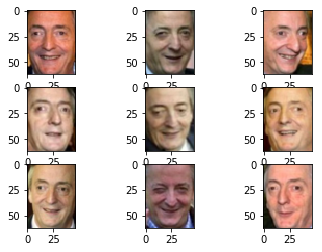

In [23]:
#produce image from vectors

from matplotlib import pyplot
from scipy.misc import toimage
lfw_people = fetch_lfw_people(min_faces_per_person=30,color=True) #resize, slice, color parameter
num_pics, h, w, d = lfw_people.images.shape
X=lfw_people.data  #this is our main training set 
n_features=X.shape[1] #basically number of pixels (h*w)
target_labels=lfw_people.target #labels of classes for each value in x
y=target_labels
target_names=lfw_people.target_names #maps target label to name
num_classes=target_names.shape[0]
#target_names[y[229]] #remember this changes in next step cause we apply random in sklearn dataset fomation

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42) #split into training and testing set
print(X_train.shape)
X_train=X_train.reshape(X_train.shape[0],62,47,3)
X_test=X_test.reshape(X_test.shape[0],62,47,3)
X_train=np.transpose(X_train,(0,3,1,2))
print(X_train.shape)
train_indices=[np.where(y_train==i)[0] for i in range(num_classes)]

    
for i, image in enumerate(train_indices[25]):
    if(i<9):
        pyplot.subplot(330 + i+1)
        pyplot.imshow(toimage(X_train[image]))

pyplot.show()
#X_train.shape

In [9]:
#import subprocess
#subprocess.run("wget https://drive.google.com/uc?export=download&confirm=1_KY&id=0Bz7KyqmuGsilT0J5dmRCM0ROVHc",shell="True")

AttributeError: 'module' object has no attribute 'run'

In [4]:
import subprocess

In [29]:
subprocess.call("ps",shell="True")

0

In [15]:
X_train[0].shape

(62, 47, 3)